<h1>OCR Model for Captcha Solving</h1>
This code demonstrates a simple OCR model built with Keras Functional API. 
The Keras Functional API can create models that are more flexible than the `tf.keras.Sequential` API, for it can handle models with non-linear topology, shared layers, multiple inputs or outputs.

A deep learning model is usually a directed acyclic graph of layers. So the functional API is a way to build graphs of layers.

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
!curl -LO https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip
!unzip -qq captcha_images_v2.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   159  100   159    0     0    191      0 --:--:-- --:--:-- --:--:--   190
100 8863k  100 8863k    0     0  1147k      0  0:00:07  0:00:07 --:--:-- 1809k
replace captcha_images_v2/ydd3g.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


<h2>Training Strategy</h2>
The dataset contains 1040 captcha files as png images. 

The label for each image is a string containing the characters as the filename. Each character in the string will be used as input to the training model. Similarly, the predictions will be mapped from integers into strings. 

In order to do this, we will maintain two dictionaries, mapping chars to int, and int to chars, respectively.

In [4]:
dataPath = Path("./captcha_images_v2")

images = sorted(list(map(str, list(dataPath.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = set(char for label in labels for char in label)

In [5]:
print(f"Number of images found: {len(images)}")
print(f"Number of labels found: {len(labels)}")
print(f"Number of unique characters: {len(characters)}")
print(f"Characters found: {characters}")

Number of images found: 1040
Number of labels found: 1040
Number of unique characters: 19
Characters found: {'4', 'p', 'e', 'b', '8', 'c', 'g', 'f', 'x', '5', 'y', '6', 'w', '2', 'n', 'm', '3', 'd', '7'}


In [6]:
batchSize = 16

imgWidth = 200
imgHeight = 50

downsampleFactor = 4

maxLength = max([len(label) for label in labels])

<h2>Preprocessing</h2>

Now we're going to perform two mappings: from characters to integers and then from integers to the original characters. For this task we're using the class `StringLookup`, this layer translates a set of arbitrary strings into integer indices via a table based vocabulary lookup. The parameter `invert=True` reverses the operation, mapping indices to vocabulary items.

Next we'll split the data into training and validation sets.

Finally, an encoding function is defined.


In [7]:
char_to_num = layers.experimental.preprocessing.StringLookup(vocabulary=list(characters), mask_token=None)

num_to_char = layers.experimental.preprocessing.StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)


In [8]:
def split_data(images, labels, trainSize=0.9, shuffle=True):
    size = len(images)
    indices = np.arange(size)
    
    if shuffle:
        np.random.shuffle(indices)
    
    trainSamples = int(size*trainSize)

    xTrain, yTrain = images[indices[:trainSamples]], labels[indices[:trainSamples]]
    xVal, yVal =  images[indices[trainSamples:]], labels[indices[trainSamples:]]

    return xTrain, xVal, yTrain, yVal

xTrain, xVal, yTrain, yVal = split_data(np.array(images), np.array(labels))

In [10]:
def encode_single_sample(imgPath, label):
    img = tf.io.read_file(imgPath)

    img = tf.io.decode_png(img, channels=1) #decodes and coverts to grayscale

    img = tf.image.convert_image_dtype(img, tf.float32)

    img = tf.image.resize(img, [imgHeight, imgWidth])

    img = tf.transpose(img, perm=[1, 0, 2])

    label = char_to_num(tf.strings.unicode_split(label, input_encoding='UTF-8'))

    return {"image": img, "label": label}

<h2>Creating Dataset Objects</h2>

The `tf.data` API enables you to build complex input pipelines from simple, reusable pieces. 

The `tf.data` API introduces a `tf.data.Dataset` abstraction that represents a sequence of elements, in which each element consists of one or more components. For example, in an image pipeline, an element might be a single training example, with a pair of tensor components representing the image and its label.

To create an input pipeline, you must start with a data source. For example, to construct a Dataset from data in memory, you can use `tf.data.Dataset.from_tensors()` or `tf.data.Dataset.from_tensor_slices()`.

Once you have a Dataset object, you can transform it into a new Dataset by chaining method calls on the `tf.data.Dataset` object. For example, you can apply per-element transformations such as `Dataset.map()`, and multi-element transformations such as `Dataset.batch()`.

`Dataset.map()` is a transformation that applies `map_func` across the elements of the dataset and returns a new dataset containing the transformed elements, in the same order as they appeared in the input. 

Performance can often be improved by setting `num_parallel_calls` so that map will use multiple threads to process elements. This arg is a `tf.int64` scalar `tf.Tensor`, representing the number elements to process asynchronously in parallel. If not specified, elements will be processed sequentially. If the value `tf.data.AUTOTUNE` is used, then the number of parallel calls is set dynamically based on available CPU.

Most dataset input pipelines should end with a call to `prefetch`. This allows later elements to be prepared while the current element is being processed. This often improves latency and throughput, at the cost of using additional memory to store prefetched elements.



In [11]:
trainDataset = tf.data.Dataset.from_tensor_slices((xTrain, yTrain))

trainDataset = (trainDataset.map(
                encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                .batch(batchSize)
                .prefetch(buffer_size=tf.data.experimental.AUTOTUNE))

validationDataset = tf.data.Dataset.from_tensor_slices((xVal,yVal))

validationDataset = (validationDataset.map(
                    encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                    .batch(batchSize)
                    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE))

<h2>Visualizing the data</h2>

<function matplotlib.pyplot.show(close=None, block=None)>

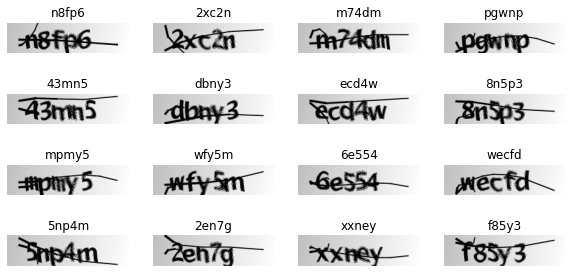

In [12]:
_, ax = plt.subplots(4, 4, figsize=(10,5))
for batch in trainDataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show


<h2>Defining the Model</h2>

In [16]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, yTrue, yPred):
        batchLen = tf.cast(tf.shape(yTrue)[0], dtype="int64")
        inputLen = tf.cast(tf.shape(yPred)[1], dtype="int64")
        labelLen = tf.cast(tf.shape(yTrue)[1], dtype="int64")

        inputLen = inputLen * tf.ones(shape=(batchLen, 1), dtype="int64")
        labelLen = labelLen * tf.ones(shape=(batchLen, 1), dtype="int64")

        loss = self.loss_fn(yTrue, yPred, inputLen, labelLen)
        self.add_loss(loss)

        return yPred

def build_model():

    inputImg = layers.Input(shape=(imgWidth, imgHeight, 1), name="image", dtype="float32")
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

     # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(inputImg)

    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)

    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    newShape = ((imgWidth // 4), (imgHeight // 4) * 64)
    x = layers.Reshape(target_shape=newShape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2")(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(inputs=[inputImg, labels], outputs=output, name="ocr_model_v1")

    # Optimizer
    opt = keras.optimizers.Adam()

    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 200, 50, 1)] 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 200, 50, 32)  320         image[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 100, 25, 32)  0           Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 100, 25, 64)  18496       pool1[0][0]                      
_______________________________________________________________________________________

<h2>Training</h2>

In [17]:
epochs = 100

earlyStoppingPatience = 10

earlyStopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=earlyStoppingPatience, restore_best_weights=True)

history = model.fit(
    trainDataset,
    validation_data=validationDataset,
    epochs=epochs,
    callbacks=[earlyStopping],
)

Epoch 1/100
59/59 [==============================] - 31s 347ms/step - loss: 21.6119 - val_loss: 16.3399
Epoch 2/100
59/59 [==============================] - 23s 396ms/step - loss: 16.3714 - val_loss: 16.2926
Epoch 3/100
59/59 [==============================] - 17s 286ms/step - loss: 16.3573 - val_loss: 16.2900
Epoch 4/100
59/59 [==============================] - 17s 297ms/step - loss: 16.3488 - val_loss: 16.2831
Epoch 5/100
59/59 [==============================] - 21s 356ms/step - loss: 16.3470 - val_loss: 16.2790
Epoch 6/100
59/59 [==============================] - 21s 355ms/step - loss: 16.3359 - val_loss: 16.2629
Epoch 7/100
59/59 [==============================] - 16s 271ms/step - loss: 16.3196 - val_loss: 16.2465
Epoch 8/100
59/59 [==============================] - 14s 245ms/step - loss: 16.2296 - val_loss: 15.9397
Epoch 9/100
59/59 [==============================] - 14s 244ms/step - loss: 15.6505 - val_loss: 14.6659
Epoch 10/100
59/59 [==============================] - 16s 279ms/

<h2>Making Inferences</h2>

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 200, 50, 1)]      0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 200, 50, 32)       320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 100, 25, 32)       0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 100, 25, 64)       18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 50, 12, 64)        0         
_________________________________________________________________
reshape (Reshape)            (None, 50, 768)           0         
_________________________________________________________________
dense1 (Dense)               (None, 50, 64)            4921

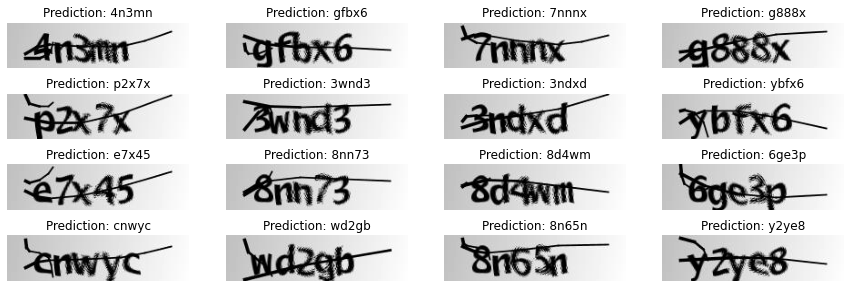

In [27]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :maxLength
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some validation samples
for batch in validationDataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()